In [9]:
import numpy as np
import pandas as pd
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils
from six.moves import cPickle as pickle

from __future__ import print_function

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

In [2]:
np.random.seed(1671)  # for reproducibility

In [3]:
pickle_file = '/home/peizhou.liao/deep_learning/Google/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset[:, np.newaxis, :, :]
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 1, 28, 28) (200000, 10)
Validation set (10000, 1, 28, 28) (10000, 10)
Test set (10000, 1, 28, 28) (10000, 10)


In [15]:
#define the convnet 
class LeNet:
    @staticmethod
    def build(input_shape, classes):
        model = Sequential()
        # CONV => RELU => POOL
        model.add(Conv2D(20, kernel_size=5, padding="same",input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        # CONV => RELU => POOL
        model.add(Conv2D(50, kernel_size=5, padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        # Flatten => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))
    
        # a softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model

In [5]:
NB_CLASSES = 10
OPTIMIZER = Adam()
BATCH_SIZE = 128
NB_EPOCH = 10
VERBOSE = 1
INPUT_SHAPE = (1, image_size, image_size)

In [10]:
# Functional API
K.set_image_dim_ordering("th")
input_layer = Input(name='image_input', shape=INPUT_SHAPE, dtype='float32')
conv_layer_1 = Conv2D(20, kernel_size=5, padding="same", activation='relu')(input_layer)
pool_layer_1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv_layer_1)
conv_layer_2 = Conv2D(50, kernel_size=5, padding="same", activation='relu')(pool_layer_1)
pool_layer_2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv_layer_2)
flatten_layer = Flatten()(pool_layer_2)
dense_1 = Dense(units=500, name='dense_1', activation='relu', dtype='float32', kernel_initializer=keras.initializers.VarianceScaling())(flatten_layer)
output_layer = Dense(units=NB_CLASSES, name='output', activation='softmax',dtype='float32',
        kernel_initializer=keras.initializers.VarianceScaling())(dense_1 )
model = Model(inputs=input_layer, outputs=output_layer)

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=OPTIMIZER,
              metrics=['accuracy'])

history = model.fit(x=train_dataset, y=train_labels,
                    batch_size=BATCH_SIZE, epochs=NB_EPOCH,
                    verbose=VERBOSE, validation_data=(valid_dataset, valid_labels))
score = model.evaluate(test_dataset, test_labels, verbose=VERBOSE)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 28, 28)        520       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 14, 14)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 14, 14)        25050     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 7, 7)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2450)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               1225500   
__________

In [21]:
# Sequential API
# pay attention to the image dim ordering
K.set_image_dim_ordering("th")
# initialize the optimizer and model
model = LeNet.build(input_shape=INPUT_SHAPE, classes=NB_CLASSES)
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,
    metrics=["accuracy"])

history = model.fit(train_dataset, train_labels, 
    batch_size=BATCH_SIZE, epochs=NB_EPOCH, 
    verbose=VERBOSE, validation_data=(valid_dataset, valid_labels))

score = model.evaluate(test_dataset, test_labels, verbose=VERBOSE)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

Train on 200000 samples, validate on 10000 samples
Epoch 1/20
200000/200000 [==============================] - 166s 830us/step - loss: 0.3757 - acc: 0.8888 - val_loss: 0.3011 - val_acc: 0.9106
Epoch 2/20
200000/200000 [==============================] - 166s 829us/step - loss: 0.2584 - acc: 0.9210 - val_loss: 0.2633 - val_acc: 0.9233
Epoch 3/20
200000/200000 [==============================] - 164s 820us/step - loss: 0.2094 - acc: 0.9349 - val_loss: 0.2547 - val_acc: 0.9210
Epoch 4/20
200000/200000 [==============================] - 161s 806us/step - loss: 0.1649 - acc: 0.9479 - val_loss: 0.2681 - val_acc: 0.9246
Epoch 5/20
200000/200000 [==============================] - 164s 821us/step - loss: 0.1226 - acc: 0.9609 - val_loss: 0.3012 - val_acc: 0.9245
Epoch 6/20
200000/200000 [==============================] - 160s 798us/step - loss: 0.0886 - acc: 0.9727 - val_loss: 0.3384 - val_acc: 0.9242
Epoch 7/20
200000/200000 [==============================] - 159s 793us/step - loss: 0.0673 - acc:

['acc', 'loss', 'val_acc', 'val_loss']


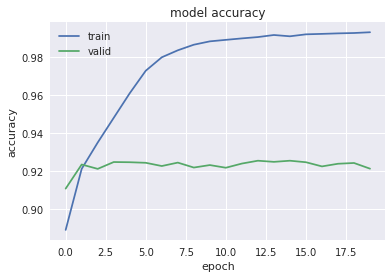

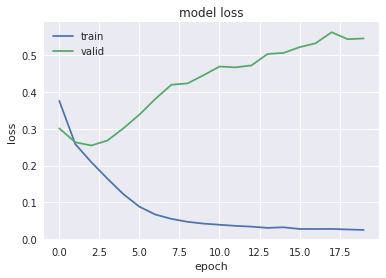

In [23]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')
plt.show()